This is a different method of hiding the train / test data... clearly doesn't work

In [211]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import ChebConv
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import ttest_ind
import networkx as nx
from torch_geometric.utils import remove_self_loops

In [225]:
dataset = torch.load('nfl_coaches_subset.pt', weights_only=False)

In [226]:
dataset.edge_index

tensor([[  0,   0,   0,  ..., 273, 274, 276],
        [  1,   2,   3,  ..., 274, 275, 277]])

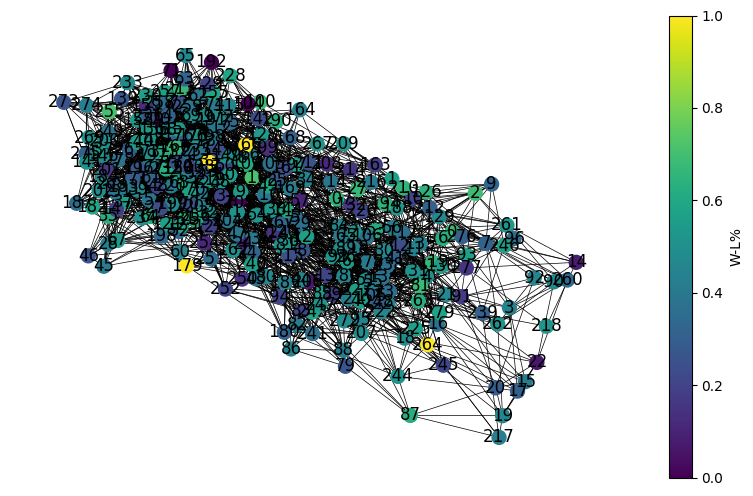

In [227]:
edges = dataset.edge_index.t().numpy()
G = nx.Graph()
G.add_edges_from(edges)

fig, ax = plt.subplots(figsize=(10,6))

pos = nx.spring_layout(G)
nx.draw(G, pos, ax=ax,
        node_color=dataset.x[:,4],
        node_size=100,
        width=0.5,
        with_labels=True,
        cmap=plt.cm.viridis
        )
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=dataset.x[:,4].min(), vmax=dataset.x[:,4].max()))
plt.colorbar(sm, ax=ax, label='W-L%')
plt.show()


In [228]:
class ChebGNN(nn.Module):
    def __init__(self, in_channels, K=3):
        super().__init__()
        self.conv1 = ChebConv(in_channels, 32, K=K)
        self.conv2 = ChebConv(32, 16, K=K)
        self.lin = nn.Linear(16, 1)
        
    def forward(self, x, edge_index, target_nodes = None):
        if target_nodes is not None:
            x = x.clone()
            x[target_nodes] = 0.0
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        out = self.lin(x)
        return out
    
class GCN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = torch.nn.Linear(in_channels, 32)
        self.conv2 = torch.nn.Linear(32, 16) 
        self.lin = nn.Linear(16, 1)
        
    def forward(self, x, edge_index = None, target_nodes = None):
        if target_nodes is not None:
            x = x.clone()
            x[target_nodes] = 0.0
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        
        out = self.lin(x)
        return out

In [229]:
def get_train_nodes(dataset, train_ratio):
    mask = torch.rand(dataset.x.shape[0]) < train_ratio
    return mask

In [230]:
train_nodes = get_train_nodes(dataset, .8)

In [231]:
dataset.x = dataset.x[:,4]

In [232]:
def run_exp(dataset, model, mask):

    edge_index = dataset.edge_index

    X = dataset.x.reshape(-1,1)
    y = dataset.x.reshape(-1,1)


    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    for epoch in range(200):
        model.train()
        optimizer.zero_grad()

        out = model(X, edge_index, target_nodes = ~mask)
        loss = criterion(out[mask], y[mask])

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            print(f"epoch {epoch + 1}, loss: {loss.item():.4f}")
        
    model.eval()
    with torch.no_grad():
        preds = model(X, edge_index, target_nodes = ~mask)
        mse = nn.MSELoss()
        print(f"MSE: {mse(preds[~mask], y[~mask]).item():.4f}")
        r2 = r2_score(y[~mask].numpy(), preds[~mask].numpy())
        print(f"R² Score: {r2:.4f}")



    return preds, y


In [233]:
model = GCN(1)
p, y  = run_exp(dataset, model, train_nodes)

epoch 20, loss: 0.0180
epoch 40, loss: 0.0009
epoch 60, loss: 0.0001
epoch 80, loss: 0.0001
epoch 100, loss: 0.0000
epoch 120, loss: 0.0000
epoch 140, loss: 0.0000
epoch 160, loss: 0.0000
epoch 180, loss: 0.0000
epoch 200, loss: 0.0000
MSE: 0.2176
R² Score: -5.8319


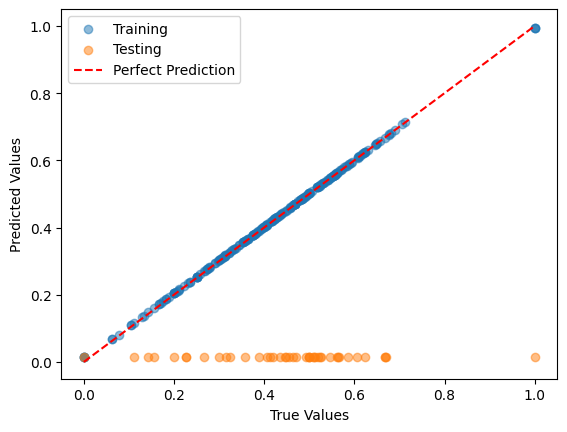

In [234]:
plt.scatter(y[train_nodes], p[train_nodes], alpha=0.5, label='Training')
plt.scatter(y[~train_nodes], p[~train_nodes], alpha=0.5, label='Testing') 
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
